# Use `Lale` `AIF360`   `DisparateImpactRemover` to  mitigate bias for credit risk AutoAI model

This notebook contains the steps and code to demonstrate support of AutoAI experiments in Watson Machine Learning service. It introduces commands for bias detecting and mitigation performed with `lale.lib.aif360` module. 

Some familiarity with Python is helpful. This notebook uses Python 3.11.

**NOTE:** The notebook is a continuation for sample notebook: <a href="https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd5.0/notebooks/python_sdk/experiments/autoai/fairness/Use%20AutoAI%20to%20train%20fair%20models.ipynb" target="_blank" rel="noopener no referrer">"Use AutoAI to train fair models"</a>. 

## Contents

This notebook contains the following parts:

1. [Setup](#setup)
2. [Load historical experiment](#definition)
3. [Pipeline bias detection and mitigation](#bias)
5. [Deployment and score](#scoring)
6. [Clean up](#cleanup)
7. [Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Contact with your Cloud Pack for Data administrator and ask him for your account credentials

### Install and import the `ibm-watsonx-ai`, `lale` ,`aif360` and dependencies.
**Note:** `ibm-watsonx-ai` documentation can be found <a href="https://ibm.github.io/watsonx-ai-python-sdk/index.html" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
!pip install wget | tail -n 1
!pip install -U ibm-watsonx-ai | tail -n 1
!pip install -U scikit-learn==1.3.0 | tail -n 1
!pip install -U autoai-libs | tail -n 1
!pip install -U 'lale[fairness]>=0.8.2' | tail -n 1

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud Pack for Data. You need to provide platform `url`, your `username` and `api_key`.

In [ ]:
username = 'PASTE YOUR USERNAME HERE'
api_key = 'PASTE YOUR API_KEY HERE'
url = 'PASTE THE PLATFORM URL HERE'

In [2]:
from ibm_watsonx_ai import Credentials

credentials = Credentials(
    username=username,
    api_key=api_key,
    url=url,
    instance_id="openshift",
    version="5.0"
)

Alternatively you can use `username` and `password` to authenticate WML services.

```python
credentials = Credentials(
    username=***,
    password=***,
    url=***,
    instance_id="openshift",
    version="5.0"
)

```

In [3]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials)

### Working with spaces

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use `{PLATFORM_URL}/ml-runtime/spaces?context=icp4data` to create one.

- Click New Deployment Space
- Create an empty space
- Go to space `Settings` tab
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd5.0/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below


In [4]:
space_id = 'PASTE YOUR SPACE ID HERE'

You can use the `list` method to print all existing spaces.


In [ ]:
client.spaces.list(limit=10)

To be able to interact with all resources available in Watson Machine Learning, you need to set the **space** which you will be using.

In [5]:
client.set.default_space(space_id)

'SUCCESS'

<a id="definition"></a>
## 2. Load historical experiment

Initialiaze AutoAI experiment with Watson Machine Learning credentials and space.  

In [6]:
from ibm_watsonx_ai.experiment import AutoAI

experiment = AutoAI(credentials, space_id=space_id)

List all previous AutoAI experiment runs named `'Credit Risk Prediction and bias detection - AutoAI'` which was run in sample notebook <a href="https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd5.0/notebooks/python_sdk/experiments/autoai/fairness/Use%20AutoAI%20to%20train%20fair%20models.ipynb" target="_blank" rel="noopener no referrer">"Use AutoAI to train fair models"</a>. 

**NOTE:** If you don't have any experiment listed below please run the <a href="https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd5.0/notebooks/python_sdk/experiments/autoai/fairness/Use%20AutoAI%20to%20train%20fair%20models.ipynb" target="_blank" rel="noopener no referrer">"Use AutoAI to train fair models"</a> notebook first and then continue running the current notebook. 

In [ ]:
autoai_experiment_name = 'Credit Risk Prediction and bias detection - AutoAI'

historical_experiments = experiment.runs(filter=autoai_experiment_name).list()
historical_experiments

Load last experiment run to variable `pipeline_optimizer`.

In [8]:
run_id = historical_experiments.run_id[0]

pipeline_optimizer= experiment.runs.get_optimizer(run_id)

In [9]:
summary = pipeline_optimizer.summary()
summary

,Enhancements,Estimator,training_accuracy_and_disparate_impact_(optimized),training_disparate_impact_Sex,training_roc_auc,holdout_disparate_impact_Sex,holdout_average_precision,holdout_log_loss,holdout_roc_auc,training_disparate_impact,...,holdout_accuracy,holdout_balanced_accuracy,training_recall,holdout_f1,training_accuracy,holdout_disparate_impact,training_balanced_accuracy,holdout_disparate_impact_Age,training_f1,training_disparate_impact_Age
Pipeline Name,,,,,,,,,,,,,,,,,,,,,
Pipeline_1,,XGBClassifier,0.676887,1.009581,0.846120,1.046499,0.480936,0.419151,0.855620,1.825512,...,0.811623,0.754275,0.894970,0.867606,0.796567,1.431694,0.748223,1.426056,0.853965,2.329145
Pipeline_2,HPO,XGBClassifier,0.676887,1.009581,0.846120,1.046499,0.480936,0.419151,0.855620,1.825512,...,0.811623,0.754275,0.894970,0.867606,0.796567,1.431694,0.748223,1.426056,0.853965,2.329145
Pipeline_3,"HPO, FE",XGBClassifier,0.681126,1.009843,0.846576,1.057825,0.481095,0.416944,0.855187,1.787199,...,0.809619,0.755745,0.892283,0.865248,0.795004,1.463687,0.747200,1.451613,0.852646,2.286728
Pipeline_4,"HPO, FE, HPO",XGBClassifier,0.681126,1.009843,0.846576,1.057825,0.481095,0.416944,0.855187,1.787199,...,0.809619,0.755745,0.892283,0.865248,0.795004,1.463687,0.747200,1.451613,0.852646,2.286728
Pipeline_5,"HPO, FE, HPO, Ensemble",BatchedTreeEnsembleClassifier(XGBClassifier),0.681126,1.009843,0.846576,1.057825,0.481095,0.416944,0.855187,1.787199,...,0.809619,0.755745,0.892283,0.865248,0.795004,1.463687,0.747200,1.451613,0.852646,2.286728


### Get selected pipeline model

Download pipeline model object from the AutoAI training job.

In [10]:
best_pipeline = pipeline_optimizer.get_pipeline()

### Get Credit Risk dataset from experiment configuration. 

In [ ]:
X_train, X_holdout, y_train, y_holdout = pipeline_optimizer.get_data_connections()[0].read(with_holdout_split=True)
X_holdout.head()

<a id="bias"></a>
## 3. Bias detection and mitigation

The `fairness_info` dictionary contains some fairness-related metadata. The favorable and unfavorable label are values of the target class column that indicate whether the loan was granted or denied. A protected attribute is a feature that partitions the population into groups whose outcome should have parity. The credit-risk dataset has two protected attribute columns, sex and age. Each prottected attributes has monitored and reference group.


In [13]:
fairness_info = pipeline_optimizer.get_params()['fairness_info']
fairness_info

{'favorable_labels': ['No Risk'],
 'protected_attributes': [{'feature': 'Sex',
   'monitored_group': ['female'],
   'reference_group': ['male']},
  {'feature': 'Age',
   'monitored_group': [[18, 25]],
   'reference_group': [[26, 75]]}],
 'unfavorable_labels': ['Risk']}

### Calculate fairness metrics

We will calculate some model metrics. Accuracy describes how accurate is the model according to dataset. 
Disparate impact is defined by comparing outcomes between a privileged group and an unprivileged group, 
so it needs to check the protected attribute to determine group membership for the sample record at hand. The closer to 1 is the value of disparate impact the less biased is the model. 
The third calculated metric takes the disparate impact into account along with accuracy. The best value of the score is 1.0.

In [14]:
import sklearn.metrics
from lale.lib.aif360 import disparate_impact, accuracy_and_disparate_impact

accuracy_scorer = sklearn.metrics.make_scorer(sklearn.metrics.accuracy_score)
print(f'accuracy {accuracy_scorer(best_pipeline, X_holdout, y_holdout):.1%}')

disparate_impact_scorer = disparate_impact(**fairness_info)
print(f'disparate impact {disparate_impact_scorer(best_pipeline, X_holdout, y_holdout):.2f}')

combined_scorer = accuracy_and_disparate_impact(**fairness_info)
print(f'accuracy and disparate impact metric {combined_scorer(best_pipeline, X_holdout, y_holdout):.2f}')

accuracy 81.2%
disparate impact 1.43
accuracy and disparate impact metric 0.76


## Refinery with lale

In this section we will use `DisparateImpactRemover` algorithm for mitigating fairness problems from `lale.lib.aif360` module. It modifies the features that are not the protected attribute in such a way that it is hard to predict the protected attribute from them. This algorithm has a hyperparameter `repair_level` that we will tune with hyperparameter optimization.

In [15]:
from lale.lib.aif360 import DisparateImpactRemover
from lale.pretty_print import ipython_display

ipython_display(DisparateImpactRemover.hyperparam_schema('repair_level'))

```python
{
    "description": "Repair amount from 0 = none to 1 = full.",
    "type": "number",
    "minimum": 0,
    "maximum": 1,
    "default": 1,
}
```

### Pipeline decomposition and new definition

Start by removing the last step of the pipeline, i.e., the final estimator.

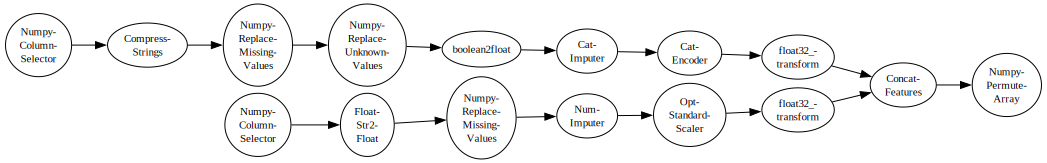

In [16]:
prefix = best_pipeline.remove_last().freeze_trainable()
prefix.visualize()

Initialize the `DisparateImpactRemover` with fairness configuration and pipeline without final estimator and add a new final step, which consists of a choice of two estimators. In this code, `|` is the or combinator (algorithmic choice). It defines a search space for another optimizer run.

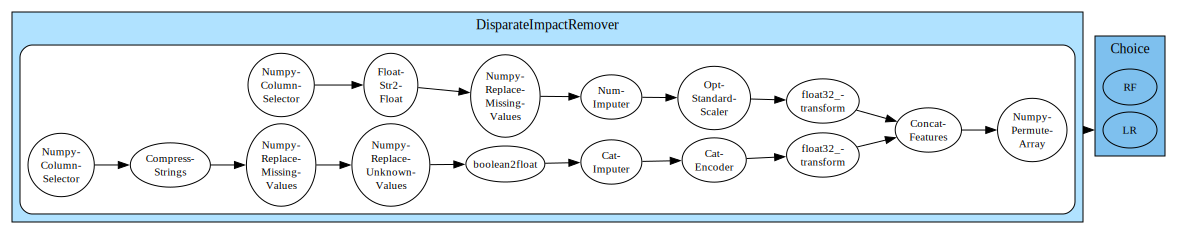

In [17]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF
from lale.operator_wrapper import wrap_imported_operators
wrap_imported_operators()

di_remover = DisparateImpactRemover(**fairness_info, preparation=prefix)
planned_fairer = di_remover >> (LR | RF)
planned_fairer.visualize()

Fairness metrics can be more unstable than accuracy, because they depend not just on the distribution of labels, but also on the distribution of privileged and unprivileged groups as defined by the protected attributes. In AI Automation, k-fold cross validation helps reduce overfitting. To get more stable results, we will stratify these k folds by both labels and groups with `FairStratifiedKFold` class.

In [18]:
from lale.lib.aif360 import FairStratifiedKFold

fair_cv = FairStratifiedKFold(**fairness_info, n_splits=3)

### Pipeline training

To automatically select the algorithm and tune its hyperparameters we use `auto_configure` method of lale pipeline. The combined metric `accuracy_and_disparate_impact` is used as scoring metric in evaluation process.   

In [19]:
from lale.lib.lale import Hyperopt

trained_fairer = planned_fairer.auto_configure(
    X_train, y_train, optimizer=Hyperopt, cv=fair_cv,
    max_evals=10, scoring=combined_scorer, best_score=1.0)

100%|██████████| 10/10 [00:29<00:00,  2.93s/trial, best loss: 0.1676332233430191]


#### Results 

Visualize the final pipeline and calculate its metrics.  

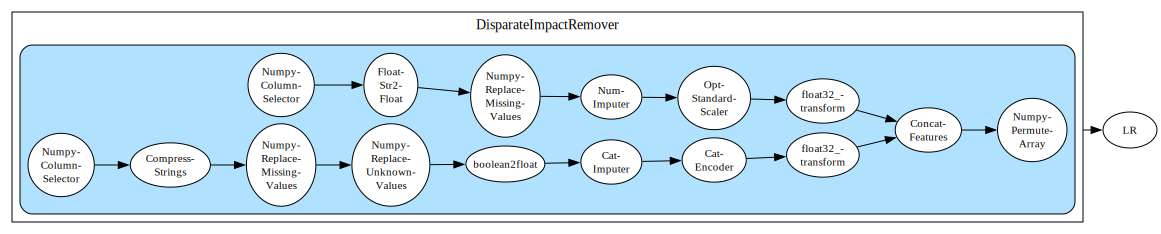

In [20]:
trained_fairer.visualize()

In [21]:
print(f'accuracy {accuracy_scorer(trained_fairer, X_holdout, y_holdout):.1%}')
print(f'disparate impact {disparate_impact_scorer(trained_fairer, X_holdout, y_holdout):.2f}')
print(f'accuracy and disparate impact metric {combined_scorer(trained_fairer, X_holdout, y_holdout):.2f}')


accuracy 66.5%
disparate impact 1.00
accuracy and disparate impact metric 0.83


**Summary:** As result of the described steps we received unbiased pipeline model based on disparate impact value, however the accuracy of the model decreased from 70% to 66%.

<a id="scoring"></a>
## 5. Deploy and Score
In this section you will learn how to deploy and score Lale pipeline model using WML instance.

#### Custom software_specification

Created model is AutoAI model refined with Lale. We will create new software specification based on default Python 3.11 environment extended by  `autoai-libs` package.

In [22]:
base_sw_spec_id = client.software_specifications.get_id_by_name("runtime-24.1-py3.11")
print("Id of default Python 3.11 software specification is: ", base_sw_spec_id)

Id of default Python 3.11 software specification is:  45f12dfe-aa78-5b8d-9f38-0ee223c47309


In [23]:
import os
import wget

url = 'https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cpd5.0/configs/config.yaml'
if not os.path.isfile('config.yaml'): wget.download(url)

In [ ]:
!cat config.yaml

`config.yaml` file describes details of package extention. Now you need to store new package extention with  `APIClient`.

In [25]:
meta_prop_pkg_extn = {
    client.package_extensions.ConfigurationMetaNames.NAME: "Scikt with autoai-libs",
    client.package_extensions.ConfigurationMetaNames.DESCRIPTION: "Pkg extension for autoai-libs",
    client.package_extensions.ConfigurationMetaNames.TYPE: "conda_yml"
}

pkg_extn_details = client.package_extensions.store(meta_props=meta_prop_pkg_extn, file_path="config.yaml")
pkg_extn_id = client.package_extensions.get_id(pkg_extn_details)
pkg_extn_url = client.package_extensions.get_href(pkg_extn_details)

Creating package extensions
SUCCESS


Create new software specification and add created package extention to it. 

In [26]:
meta_prop_sw_spec = {
    client.software_specifications.ConfigurationMetaNames.NAME: "Mitigated AutoAI bases on scikit spec",
    client.software_specifications.ConfigurationMetaNames.DESCRIPTION: "Software specification for scikt with autoai-libs",
    client.software_specifications.ConfigurationMetaNames.BASE_SOFTWARE_SPECIFICATION: {"guid": base_sw_spec_id}
}

sw_spec_details = client.software_specifications.store(meta_props=meta_prop_sw_spec)
sw_spec_id = client.software_specifications.get_id(sw_spec_details)


status = client.software_specifications.add_package_extension(sw_spec_id, pkg_extn_id)

SUCCESS


You can get details of created software specification using `client.software_specifications.get_details(sw_spec_id)`

### Store the model

In [27]:
model_props = {
    client.repository.ModelMetaNames.NAME: "Fairer AutoAI model",
    client.repository.ModelMetaNames.TYPE: 'scikit-learn_1.3',
    client.repository.ModelMetaNames.SOFTWARE_SPEC_ID: sw_spec_id
    
}
feature_vector = list(X_train.columns)

In [28]:
published_model = client.repository.store_model(
    model=best_pipeline.export_to_sklearn_pipeline(), 
    meta_props=model_props,
    training_data=X_train.values,
    training_target=y_train.values,
    feature_names=feature_vector,
    label_column_names=['Risk']
)

In [29]:
published_model_id = client.repository.get_model_id(published_model)

### Deployment creation

In [30]:
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "Deployment of fairer model",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

created_deployment = client.deployments.create(published_model_id, meta_props=metadata)



######################################################################################

Synchronous deployment creation for id: '574c1354-017c-4f2a-b307-9263504e0297' started

######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
.........
ready


-----------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_id='825a4e20-25e2-4d56-9c30-8868e702431c'
-----------------------------------------------------------------------------------------------




In [31]:
deployment_id = client.deployments.get_id(created_deployment)

#### Deployment scoring 

You need to pass scoring values as input data if the deployed model. Use `client.deployments.score()` method to get predictions from deployed model. 

In [32]:
values = X_holdout.values

scoring_payload = {
    "input_data": [{
        'values': values[:5]
    }]
}

In [33]:
predictions = client.deployments.score(deployment_id, scoring_payload)
predictions

{'predictions': [{'fields': ['prediction', 'probability'],
   'values': [['No Risk', [0.7776124477386475, 0.22238758206367493]],
    ['No Risk', [0.7723912596702576, 0.22760875523090363]],
    ['No Risk', [0.7723912596702576, 0.22760875523090363]],
    ['No Risk', [0.7541248202323914, 0.24587517976760864]],
    ['No Risk', [0.7541248202323914, 0.24587517976760864]]]}]}

<a id="cleanup"></a>
## 5. Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd5.0/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## 6. Summary and next steps

 You successfully completed this notebook!.

Check out used packeges domuntations:
- `ibm-watsonx-ai` [Online Documentation](https://ibm.github.io/watsonx-ai-python-sdk/index.html)
- `lale`: https://github.com/IBM/lale
- `aif360`: https://aif360.mybluemix.net/

### Authors 

**Dorota Lączak**, software engineer in Watson Machine Learning at IBM

Copyright © 2022-2025 IBM. This notebook and its source code are released under the terms of the MIT License.